# Построение модели с обработкой данных SQL запросами

В данной задаче нам представлены данные в которых ключевое поле — это то, просрочит ли клиент микро-финансовой организации выплату более чем на 60 дней или нет. 
Нам нужно построить модель, которая по входным данным предсказывала бы с максимальной точностью ключе-вой параметр. 
Основной параметр это delinq60plus. Остальные парамет-ры интуитивно понятны из таблиц.
# Цель

Построить модель машинного обучения для предсказания вероятности того, что клиент уйдет в просрочку более 60 дней.

# Задача
осуществить корректную загрузку данных
осуществить разведывательный анализ данных:
- разбить выборку на обучающую и тестовую
- проанализировать пропуски и решить, что с ними делать
- проанализировать выбросы
- создать/ удалить переменные
- закодировать категориальные переменные
- нормализовать числовые переменные (при необходимости)

построить модель и оценить ее качество
при необходимости вернуться к предыдущим шагам, чтобы улучшить качество модели


# Высокая цель. Использовать (не везде, а где мы работаем с данными напрямую) SQL запросы. 

Ожидаемый результат:
AUC на обучающей выборке: 0.865
AUC на контрольной выборке: 0.854
Рекомендую построить Confusion matrix что бы понять как ваша модель ошибаеться. 

ПС: В реальных задачах могут быть требования что бы мы например угадывали 99% плохих транзакций. Попробуйте поиграться с весами. ПСС - нейронные сети не дадут тут результат сильно лучше классических методов. 


## Подгрузим необходимые библиотеки и данные

In [165]:
!pip install catboost

     -------------------------------------- 101.0/101.0 MB 6.1 MB/s eta 0:00:00
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


In [167]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sqlite3

import catboost as cat
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, precision_score, \
              recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, \
              auc, mean_squared_error, accuracy_score

In [209]:
df = pd.read_csv("MFOcredit.csv", encoding='cp1251', sep=';', index_col='id')
display(df.head(5))

,date_start,date_end,gender,age,auto,housing,marstatus,regclient,jobtype,region,credits,children,delinq60plus
id,,,,,,,,,,,,,
1,03-Jan-2013,12-Jan-2013,Мужской,44,Нет,Собственное,Гражданский брак/женат/замужем,Нет,Официальное,Новосибирская область,Нет,Да,Нет
2,03-Jan-2013,17-Jan-2013,Мужской,21,Пропуск поля,Живут с родителями,Холост,Нет,Официальное,Кемеровская область юг,Да,Нет,Нет
3,03-Jan-2013,17-Jan-2013,Мужской,25,Пропуск поля,Собственное,Холост,Да,Официальное,Кемеровская область север,Пропуск поля,Нет,Нет
4,03-Jan-2013,17-Jan-2013,Женский,47,Пропуск поля,Собственное,Гражданский брак/женат/замужем,Да,Официальное,Кемеровская область север,Нет,Нет,Нет
5,03-Jan-2013,17-Jan-2013,Мужской,22,Нет,Арендуемое,Гражданский брак/женат/замужем,Нет,Официальное,Кемеровская область север,Да,Да,Нет


### Преобразуем даты в формат datetime

In [210]:
df['date_start'] = pd.to_datetime(df['date_start'],format='%d-%b-%Y')
df['date_end'] = pd.to_datetime(df['date_end'],format='%d-%b-%Y')

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35212 entries, 1 to 35212
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_start    35212 non-null  datetime64[ns]
 1   date_end      35212 non-null  datetime64[ns]
 2   gender        35212 non-null  object        
 3   age           35212 non-null  int64         
 4   auto          35212 non-null  object        
 5   housing       35212 non-null  object        
 6   marstatus     35212 non-null  object        
 7   regclient     35212 non-null  object        
 8   jobtype       35212 non-null  object        
 9   region        35212 non-null  object        
 10  credits       35212 non-null  object        
 11  children      35212 non-null  object        
 12  delinq60plus  35212 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(10)
memory usage: 3.8+ MB


In [212]:
df['age'].describe()

count    35212.000000
mean        37.243525
std         13.183961
min         18.000000
25%         26.000000
50%         34.000000
75%         48.000000
max         75.000000
Name: age, dtype: float64

Из числовых значений только возраст, в нем выбросов нет

### Посмотрим на остальные значения

In [213]:
df['gender'].value_counts()

Женский    18275
Мужской    16937
Name: gender, dtype: int64

In [214]:
df['auto'].value_counts()

Нет             17465
Пропуск поля    14077
Да               3670
Name: auto, dtype: int64

In [215]:
df['housing'].value_counts()

Собственное              18099
Пропуск поля              7603
Живут с родителями        3177
Долевая собственность     2955
Арендуемое                2020
Муниципальное             1358
Name: housing, dtype: int64

In [216]:
df['marstatus'].value_counts()

Гражданский брак/женат/замужем    14099
Холост                             8833
Пропуск поля                       7564
Разведен                           2871
Вдова/вдовец                       1845
Name: marstatus, dtype: int64

In [217]:
df['regclient'].value_counts()

Да     19733
Нет    15479
Name: regclient, dtype: int64

In [218]:
df['jobtype'].value_counts()

Официальное      19588
Пропуск поля     14457
Неофициальное     1167
Name: jobtype, dtype: int64

In [219]:
df['region'].value_counts()

Кемеровская область север    12447
Кемеровская область юг       11022
Алтайский край                5172
Новосибирская область         4327
Красноярский край             2244
Name: region, dtype: int64

In [220]:
df['credits'].value_counts()

Нет             18126
Да              16140
Пропуск поля      946
Name: credits, dtype: int64

In [221]:
df['children'].value_counts()

Нет             21141
Да              13326
Пропуск поля      745
Name: children, dtype: int64

In [222]:
df['delinq60plus'].value_counts()

Нет    21705
Да     13507
Name: delinq60plus, dtype: int64

Можно заметить что очень много пропусков полей, однако в целевой переменной нет пропущенных полей. Видимо при заполнении таблицы, если информация отсутствовала - поле оставляли пустым. Думаю лучше не выбрасывать пропущенные значения.

### Создадим базу данных и достанем оттуда данные параллельно их преобразовав

In [223]:
con = sqlite3.connect('HW_db')

In [224]:
df.to_sql('MFOcredit',con,index=False,if_exists='replace')

35212

In [225]:
sql = '''SELECT
CAST(julianday(t.date_end) - julianday(t.date_start) AS INTEGER) AS using_days,

CASE WHEN gender = 'Мужской' THEN 1 ELSE 0 END AS gender,

t.age,

CASE WHEN auto = 'Да' THEN 1 ELSE 0 END AS a_y,
       CASE WHEN auto = 'Нет' THEN 1 ELSE 0 END AS a_n,
       CASE WHEN auto = 'Пропуск поля' THEN 1 ELSE 0 END AS a_miss,

CASE WHEN housing = 'Собственное' THEN 1 ELSE 0 END AS h_oun,
       CASE WHEN housing = 'Живут с родителями' THEN 1 ELSE 0 END AS h_par,
       CASE WHEN housing = 'Долевая собственность' THEN 1 ELSE 0 END AS h_ap,
       CASE WHEN housing = 'Арендуемое' THEN 1 ELSE 0 END AS h_ren,
       CASE WHEN housing = 'Муниципальное' THEN 1 ELSE 0 END AS h_mun,       
       CASE WHEN housing = 'Пропуск поля' THEN 1 ELSE 0 END AS h_miss,

CASE WHEN marstatus = 'Гражданский брак/женат/замужем' THEN 1 ELSE 0 END AS m_m,
       CASE WHEN marstatus = 'Холост' THEN 1 ELSE 0 END AS m_s,
       CASE WHEN marstatus = 'Разведен' THEN 1 ELSE 0 END AS m_d,
       CASE WHEN marstatus = 'Вдова/вдовец' THEN 1 ELSE 0 END AS m_ren,
       CASE WHEN marstatus = 'Пропуск поля' THEN 1 ELSE 0 END AS m_miss,
       
CASE WHEN regclient = 'Да' THEN 1 ELSE 0 END AS regclient,

CASE WHEN jobtype = 'Официальное' THEN 1 ELSE 0 END AS j_of,
       CASE WHEN jobtype = 'Неофициальное' THEN 1 ELSE 0 END AS j_un,
       CASE WHEN jobtype = 'Пропуск поля' THEN 1 ELSE 0 END AS j_miss,
       
CASE WHEN region = 'Кемеровская область север' THEN 1 ELSE 0 END AS r_kn,
       CASE WHEN region = 'Кемеровская область юг' THEN 1 ELSE 0 END AS r_ks,
       CASE WHEN region = 'Алтайский край' THEN 1 ELSE 0 END AS r_al,
       CASE WHEN region = 'Новосибирская область' THEN 1 ELSE 0 END AS r_no,
       CASE WHEN region = 'Красноярский край' THEN 1 ELSE 0 END AS r_kr,

CASE WHEN credits = 'Да' THEN 1 ELSE 0 END AS c_y,
       CASE WHEN credits = 'Нет' THEN 1 ELSE 0 END AS c_n,
       CASE WHEN credits = 'Пропуск поля' THEN 1 ELSE 0 END AS c_miss,
       
CASE WHEN children = 'Да' THEN 1 ELSE 0 END AS ch_y,
       CASE WHEN children = 'Нет' THEN 1 ELSE 0 END AS ch_n,
       CASE WHEN children = 'Пропуск поля' THEN 1 ELSE 0 END AS ch_miss,

CASE WHEN delinq60plus = 'Да' THEN 1 ELSE 0 END AS delinq60plus

FROM MFOcredit AS t'''

In [226]:
def select(sql, con):
    return pd.read_sql(sql, con)

In [227]:
f = select(sql, con)

In [228]:
f

,using_days,gender,age,a_y,a_n,a_miss,h_oun,h_par,h_ap,h_ren,...,r_al,r_no,r_kr,c_y,c_n,c_miss,ch_y,ch_n,ch_miss,delinq60plus
0,9,1,44,0,1,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0
1,14,1,21,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,14,1,25,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,14,0,47,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,14,1,22,0,1,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35207,14,1,30,1,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0
35208,14,0,57,0,1,0,1,0,0,0,...,1,0,0,1,0,0,0,1,0,0
35209,14,0,38,0,0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
35210,14,0,19,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


<AxesSubplot:>

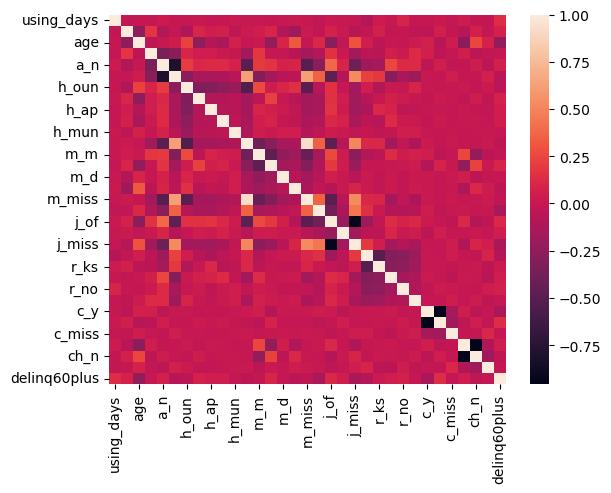

In [229]:
sns.heatmap(f.corr())

In [230]:
X = f.drop(["delinq60plus"], axis=1)
y = f["delinq60plus"]

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## GradientBoostingClassifier 

In [232]:
gbc = GradientBoostingClassifier(n_estimators = 200,
                                max_depth = 4,
                                random_state = 42)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=200, random_state=42)

In [233]:
y_pred_gbc = gbc.predict(X_test)

In [234]:
(precision_score(y_test, y_pred_gbc, average='weighted'), 
recall_score(y_test, y_pred_gbc, average='weighted'), 
f1_score(y_test, y_pred_gbc), 
roc_auc_score(y_test, y_pred_gbc))

(0.6542274054501075,
 0.6671589230943996,
 0.46139705882352944,
 0.6104936803022887)

In [235]:
confusion_matrix(y_test, y_pred_gbc)

array([[4618,  847],
       [2083, 1255]], dtype=int64)

Text(0, 0.5, 'Точность')

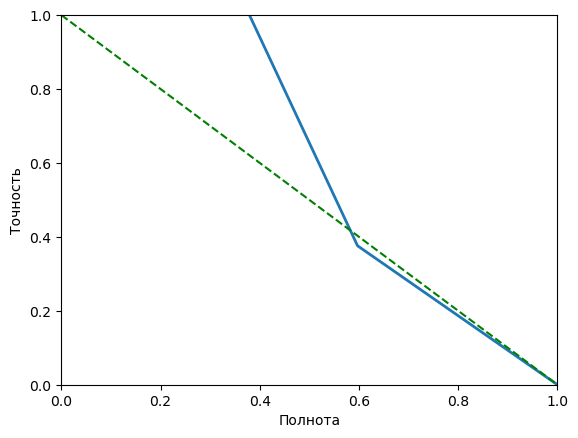

In [236]:
pre, rec, tr = precision_recall_curve(y_test, y_pred_gbc)
plt.plot(pre, rec, linewidth = 2)
plt.plot([0,1], [1,0], 'g--')
plt.axis([0,1,0,1])
plt.xlabel('Полнота')
plt.ylabel('Точность')

## CatBoostClassifier

In [237]:
cb = cat.CatBoostClassifier()

In [238]:
cb.fit(X_train, y_train, verbose=False)

In [239]:
y_pred_cb = cb.predict(X_test)

In [240]:
(precision_score(y_test, y_pred_cb, average='weighted'), 
recall_score(y_test, y_pred_cb, average='weighted'), 
f1_score(y_test, y_pred_cb), 
roc_auc_score(y_test, y_pred_cb))

(0.6556044074949056,
 0.6682948994660911,
 0.46831755280407866,
 0.6132158619287069)

Text(0, 0.5, 'Точность')

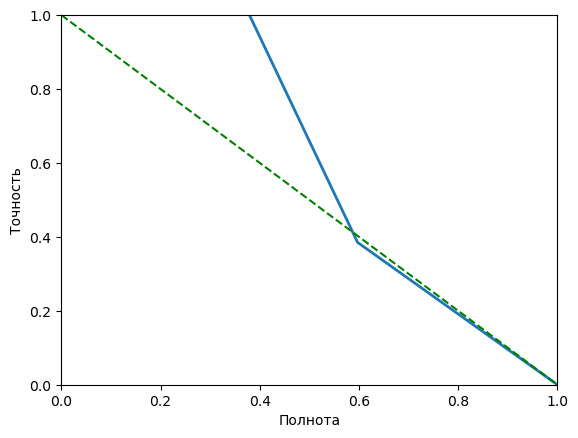

In [241]:
pre, rec, tr = precision_recall_curve(y_test, y_pred_cb)
plt.plot(pre, rec, linewidth = 2)
plt.plot([0,1], [1,0], 'g--')
plt.axis([0,1,0,1])
plt.xlabel('Полнота')
plt.ylabel('Точность')

## LogisticRegression

In [242]:
from sklearn.linear_model import LogisticRegression

In [243]:
model = LogisticRegression()

In [244]:
model.fit(X_train, y_train)

D:\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [246]:
y_pred_model = model.predict(X_test)

In [247]:
(precision_score(y_test, y_pred_model, average='weighted'), 
recall_score(y_test, y_pred_model, average='weighted'), 
f1_score(y_test, y_pred_model), 
roc_auc_score(y_test, y_pred_model))

(0.6526378889654499,
 0.6657957514483699,
 0.4641165755919854,
 0.6105034653223822)

Text(0, 0.5, 'Точность')

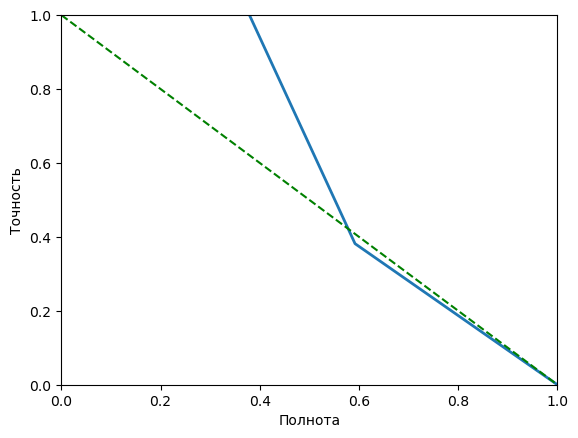

In [248]:
pre, rec, tr = precision_recall_curve(y_test, y_pred_model)
plt.plot(pre, rec, linewidth = 2)
plt.plot([0,1], [1,0], 'g--')
plt.axis([0,1,0,1])
plt.xlabel('Полнота')
plt.ylabel('Точность')